In [1]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import warnings
import keras_tuner as kt

from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam

In [3]:
dataset, metadata = tfds.load('beans', with_info=True, as_supervised=True)
train_dataset = dataset['train']
class_names = metadata.features['label'].names
print(class_names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.1EZ7TD_0.1.0/beans-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.1EZ7TD_0.1.0/beans-validation.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.1EZ7TD_0.1.0/beans-test.tfrecord*...:   0%|          | 0/…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.
['angular_leaf_spot', 'bean_rust', 'healthy']


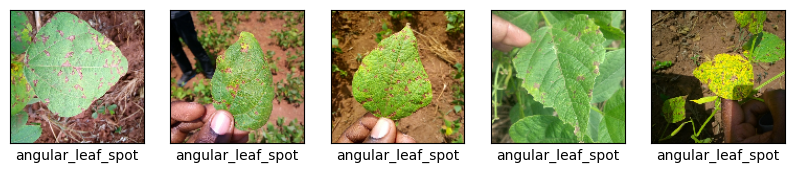

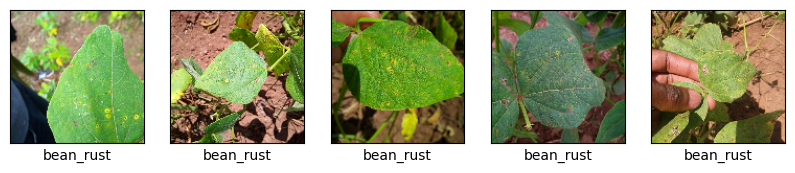

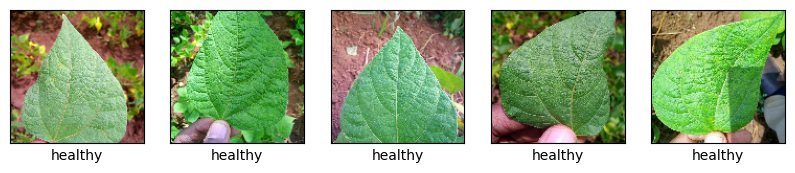

In [4]:
# Функция для отображения изображений
def display_images(dataset, class_name, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, (image, _) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image[i].numpy())
        plt.xlabel(class_name)
    plt.show()

# Подготовка изображений
def normalize_and_resize(image, label):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

for class_name in class_names:
    target_class_index = class_names.index(class_name)
    filtered_dataset = train_dataset.filter(lambda image, label: label == target_class_index)
    display_images(filtered_dataset.map(normalize_and_resize).batch(32), class_name)

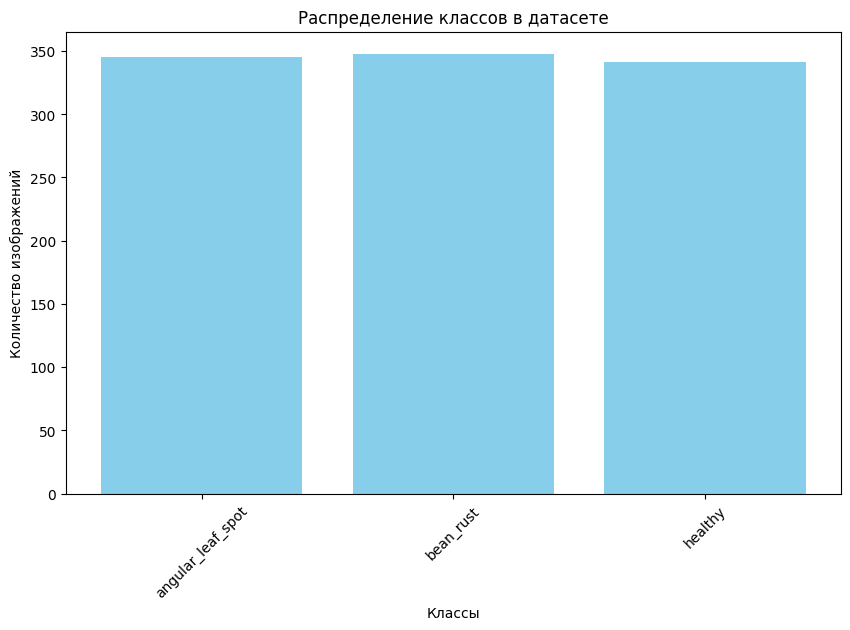

In [5]:
# Функция для распределения классов и построения гистограммы
def display_class_distribution(dataset, class_names):
    # Подсчет количества изображений в каждом классе
    class_counts = np.zeros(len(class_names), dtype=int)
    for _, label in dataset:
        class_counts[label.numpy()] += 1

    # Построение гистограммы распределения
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_counts, color='skyblue')
    plt.xlabel('Классы')
    plt.ylabel('Количество изображений')
    plt.title('Распределение классов в датасете')
    plt.xticks(rotation=45)
    plt.show()

display_class_distribution(train_dataset, class_names)

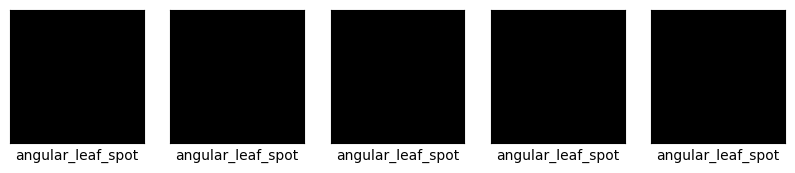

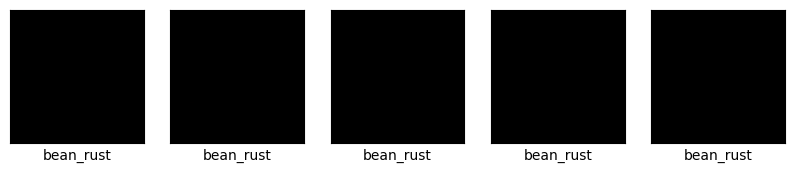

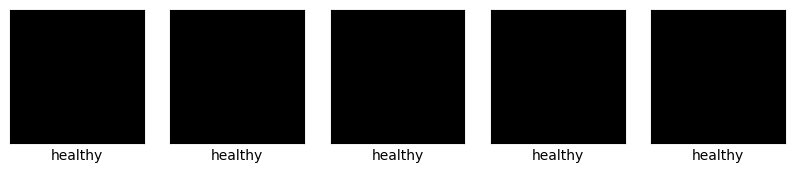

In [6]:
# Добавление меток классам (т.к. 3 класса, то 0 для 1 класса, 1 для 2 класса и 2 для 3 класса)
train_datasets = []
for class_index, class_name in enumerate(class_names):
    class_dataset = train_dataset.filter(lambda image, label: label == class_index)
    class_dataset = class_dataset.map(lambda image, _: (image, class_index))
    train_datasets.append(class_dataset)

# Функция для аугментации изображений
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Аугментация изображений
train_dataset = [ds.map(augment) for ds in train_datasets]

# Объединение классов с балансировкой
dataset = tf.data.Dataset.sample_from_datasets(train_datasets, weights=[1/len(train_datasets)] * len(train_datasets))

# Функция для добавления шума
def add_noise(image, label):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    image = image + noise
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# Нормализация и стандартизация размеров
dataset = dataset.map(normalize_and_resize)

# Добавление шума
dataset = dataset.map(add_noise)

# Перемешивание данных
dataset = dataset.shuffle(buffer_size=1000)

# Отображение получившихся изображений
for class_index, class_name in enumerate(class_names):
    filtered_dataset_after = dataset.filter(lambda image, label: label == class_index)
    display_images(filtered_dataset_after.map(normalize_and_resize).batch(32), class_name)

In [7]:
# Функция разделения датасета на обучающую и тестовую
def train_test_dataset(dataset, train_fraction=0.8):
    dataset = dataset.shuffle(buffer_size=1000)
    dataset_size = sum(1 for _ in dataset)
    train_size = int(train_fraction * dataset_size)
    train_dataset = dataset.take(train_size).batch(batch_size)
    test_dataset = dataset.skip(train_size).batch(batch_size)
    return train_dataset, test_dataset

batch_size = 32

train_dataset, test_dataset = train_test_dataset(dataset)
train_batches = sum(1 for _ in train_dataset)
test_batches = sum(1 for _ in test_dataset)

print(f'Количество обучающих батчей: {train_batches}')
print(f'Количество тестовых батчей: {test_batches}')

Количество обучающих батчей: 26
Количество тестовых батчей: 7


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     26/Unknown 5s 82ms/step - accuracy: 0.3365 - loss: 10.2259

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.3377 - loss: 10.1243 - val_accuracy: 0.5217 - val_loss: 2.6879
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.4534 - loss: 2.1893 - val_accuracy: 0.4348 - val_loss: 1.5506
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.5377 - loss: 1.3450 - val_accuracy: 0.5797 - val_loss: 1.0664
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.5995 - loss: 0.9946 - val_accuracy: 0.3913 - val_loss: 1.7414
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.6036 - loss: 1.0990 - val_accuracy: 0.6957 - val_loss: 0.8333
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.6695 - loss: 0.8139 - val_accuracy: 0.7778 - val_loss: 0.5569
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.6975 - loss: 0.7991 - val_accuracy: 0.7150 - val_loss: 0.6921
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.7247 - loss: 0.7363 - val_accuracy: 0.6715 - va

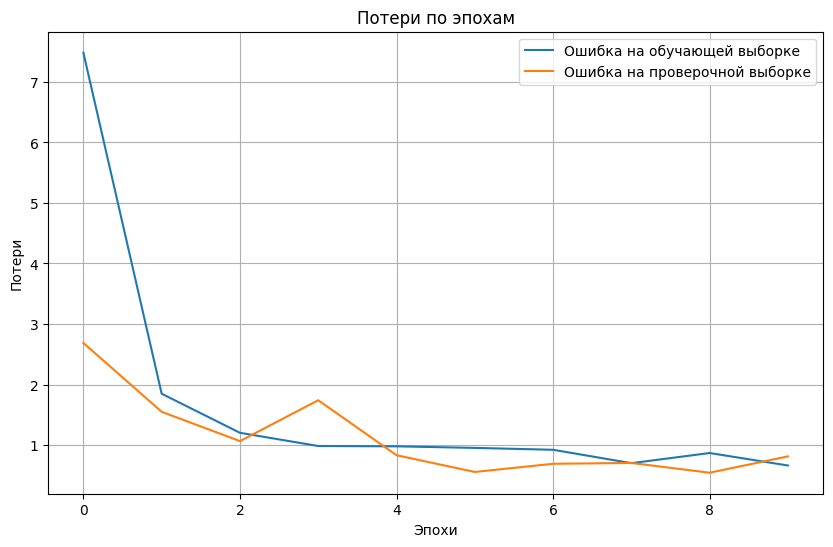

In [8]:
# Обучение модели
model = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 3)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

train_loss, train_accuracy = model.evaluate(train_dataset)
print(f'Ошибка на обучающей выборке: {train_loss:.3f}, Точность(accuracy): {train_accuracy:.3f}')
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Ошибка на проверочной выборке: {test_loss:.3f}, Точность(accuracy): {test_accuracy:.3f}')

train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss_values, label='Ошибка на обучающей выборке')
plt.plot(val_loss_values, label='Ошибка на проверочной выборке')
plt.title('Потери по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def build_model(hp):
    model = models.Sequential([
        layers.Flatten(input_shape=(128, 128, 3)),
        layers.Dense(hp.Int('neurons1', min_value=64, max_value=256, step=32), activation='relu'),
        layers.Dense(hp.Int('neurons2', min_value=32, max_value=128, step=16), activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])

    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настраиваем Hyperband
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,  # Ограничение на 5 эпох, чтобы ускорить процесс обучения
    factor=3,  # Агрессивное сокращение конфигураций
    hyperband_iterations=3,  # Ограничение на 3 итерации (чем меньше, тем быстрее)
    directory='my_dir',
    project_name='beans_classification'
)

# Запуск поиск лучших гиперпараметров
tuner.search(train_dataset, validation_data=test_dataset, epochs=5)

# Извлечение лучших гиперпараметров
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Лучшие гиперпараметры: нейроны в первом слое - {best_hps.get('neurons1')}, "
      f"нейроны во втором слое - {best_hps.get('neurons2')}, "
      f"скорость обучения - {best_hps.get('learning_rate')}")

Trial 30 Complete [00h 01m 45s]
val_accuracy: 0.7149758338928223

Best val_accuracy So Far: 0.7632850408554077
Total elapsed time: 00h 22m 14s
Лучшие гиперпараметры: нейроны в первом слое - 160, нейроны во втором слое - 64, скорость обучения - 0.00017582830568982553


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.3611 - loss: 2.9881 - val_accuracy: 0.4976 - val_loss: 1.0207
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.5691 - loss: 0.9550 - val_accuracy: 0.5942 - val_loss: 0.8788
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.5821 - loss: 0.8814 - val_accuracy: 0.5024 - val_loss: 1.0004
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.5460 - loss: 0.9479 - val_accuracy: 0.6184 - val_loss: 0.8884
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.5837 - loss: 0.8643 - val_accuracy: 0.6135 - val_loss: 0.8096
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.6501 - loss: 0.7727 - val_accuracy: 0.7343 - val_loss: 0.5973
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.6618 - loss: 0.7612 - val_accuracy: 0.7488 - val_loss: 0.6107
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.7153 - loss: 0.6954 - val_accuracy

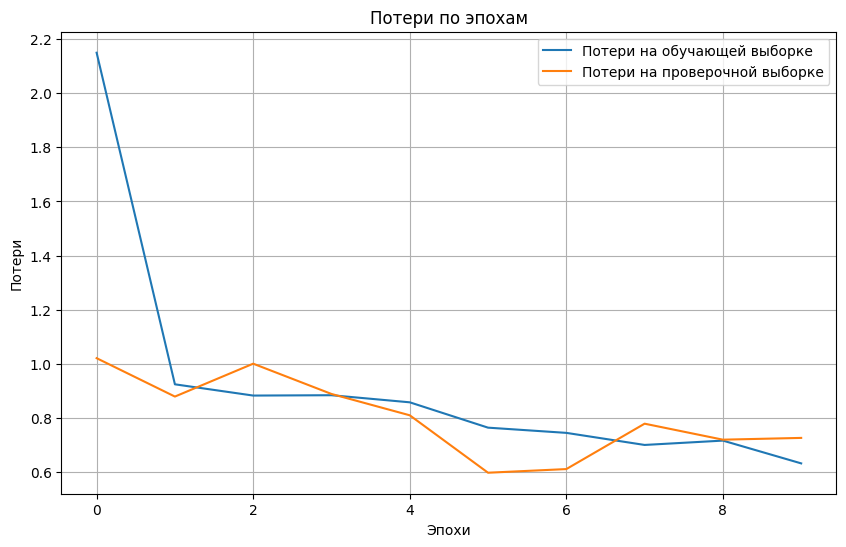

In [12]:
neurons1 = best_hps.get('neurons1')
neurons2 = best_hps.get('neurons2')
learning_rate = best_hps.get('learning_rate')

best_model = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 3)),
    layers.Dense(neurons1, activation='relu'),
    layers.Dense(neurons2, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

best_optimizer = Adam(learning_rate=learning_rate)
best_model.compile(optimizer=best_optimizer,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

best_history = best_model.fit(train_dataset, epochs=10, validation_data=test_dataset)

best_train_loss, best_train_accuracy = best_model.evaluate(train_dataset)
print(f'Обучение с лучшими параметрами\n Потери(loss): {best_train_loss:.3f}, Точность(accuracy): {best_train_accuracy:.3f}')
best_test_loss, best_test_accuracy = best_model.evaluate(test_dataset)
print(f'Тестирование с лучшими параметрами\n Потери(loss): {test_loss:.3f}, Точность(accuracy): {test_accuracy:.3f}')

best_train_loss_values = best_history.history['loss']
best_val_loss_values = best_history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(best_train_loss_values, label='Потери на обучающей выборке')
plt.plot(best_val_loss_values, label='Потери на проверочной выборке')
plt.title('Потери по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)
plt.show()